In [1]:
# coding: utf-8
import os,sys
sys.path.append(os.pardir)  #| 부모 디렉터리의 파일을 가져올 수 있도록 설정
sys.path.append("/Users/yunsu/mysite-projects/selenium")
import numpy as np
from net.deep_convnet import DeepConvNet
from dataset.ocrdata import load_dataset
import pickle, string
from python_ocr import *
from PIL import Image
from matplotlib import pyplot as plt


file_path = '/Users/yunsu/Desktop/book_reading/study_by_self/load/ocrparams2.pk1'
network = DeepConvNet(output_size=26, file_path=file_path)  
(x_train, t_train), (x_test, t_test) = load_dataset()


loading param pickles
done
loadind data pickles
done


In [4]:
url = "/Users/yunsu/desktop/python_ocr/ocr_test1.png"

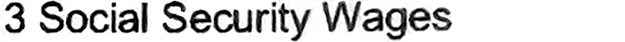

In [17]:
lines[0]

In [98]:
pos , max_wit = x_cordinate(img=lines[0])

In [99]:
a = pos[0]
a.append(pos[1][-1])
b = pos[1]
b.insert(0,0)
thre = 5
space_list = []
idx = 0
for x, y in zip(a, b):
    if abs(x - y) > thre:
        space_list.append(idx)
    idx += 1


In [59]:
space

NameError: name 'space' is not defined

In [70]:
def crop_(url):
    ful_img = Image.open(url)
    plt.imshow(ful_img)
    plt.axis("off")
    plt.show()
    lines = y_crop(url=url)
    characters = {}
    space_dic = {}
    for idx, line in enumerate(lines):
        characters["line" + str(idx + 1)] = []
        width,height = line.size
        cropby, max_wit = x_cordinate(img=line)
        space_dic['line' + str(idx + 1)] = find_space(cropby)
        for pos in range(len(cropby[0])):
            char = line.crop((cropby[0][pos], 0, cropby[1][pos], height))
            top, bot = y_cordinate_(img=char)
            w, h = char.size
            char = char.crop((0, top[0], w, bot[0]))
            hgt = bot[0] - top[0]
            extra_h = height - hgt
            wit = cropby[1][pos] - cropby[0][pos]
            extra_w = max_wit - wit 
            arr = np.array(char)
            arr = add_row(arr, where='high', n=extra_h//2)
            arr = add_row(arr, where='low', n=extra_h//2)
            arr = add_col(arr, where="left", n=extra_w//2 )
            arr = add_col(arr, where='right', n=extra_w//2)
            char = Image.fromarray(arr)
            characters["line" + str(idx + 1)].append(char)
    
    return characters, space_dic

def find_space(cropby):
    poss = cropby[0].copy(), cropby[1].copy()
    a = poss[0]
    a.append(poss[1][-1])
    b = poss[1]
    b.insert(0,0)
    thre = 5
    space_list = []
    idx = 0
    for x, y in zip(a, b):
        if abs(x - y) > thre:
            space_list.append(idx)
        idx += 1
    return space_list

In [126]:
# coding: utf-8
import string
import os,sys
import collections
sys.path.append(os.pardir)  #| 부모 디렉터리의 파일을 가져올 수 있도록 설정
sys.path.append("/Users/yunsu/mysite-projects/selenium")
import numpy as np
from net.deep_convnet2 import DeepConvNet
from dataset.ocrdata import load_dataset
import pickle
from python_ocr import *
from PIL import Image
from matplotlib import pyplot as plt

def chrs_process(char):
    if char.size[0]< 28 and char.size[1] <28:
        tmp = round(28/max(char.size) + 0.5)
        t = (char.size[0]*tmp, char.size[1]*tmp)
        char = char.resize(t)
        char.thumbnail((28, 28))
        char = char.convert("L")
        char = np.array(char)
        mask = (char >=170)
        char[mask] = 255
        char = make_matrix(char, size=(28,28))
        char = clean_(char)
        char = make_matrix(char, size=(28,28))

    else:
        vw, vh = vacant_margin(char)
        thumb_size = (28, 28)
        if max(vw, vh) <= 4:
            if max(vw, vh) <= 1:
                thumb_size = (24, 24)
            elif max(vw, vh) <= 2:
                thumb_size = (25, 25)
            elif max(vw, vh) <= 3:
                thumb_size = (26, 26)
            else:
                thumb_size = (27, 27)

        elif max(vw, vh) > 4 and vh <= 2:
            thumb_size = (24, 24)
        char.thumbnail(thumb_size)
        char = char.convert("L")
        char = np.array(char)
        char = clean_(char)
        char = make_matrix(char, size=(28,28))
        char = make_center(arr=char)

    return char


def ocr(chrs, x_helper, space_dic):
    idx = 0
    enter = [0]
    phrase = []
    num_lines = len(chrs)
    for i in range(1, num_lines + 1):
        line = 'line' + str(i)
        for char in chrs[line]:
            char = chrs_process(char)
            char = char.reshape(1,28,28)
            phrase.append(char)
            idx += 1

        enter.append(idx)

    phrase = np.array(phrase)
    num = phrase.shape[0]
    x_helper[0:num] = phrase
#     file_path = '/Users/yunsu/Desktop/book_reading/study_by_self/load/ocrparams/E_D_all_FNx1_FNT1_1.pk1'
    file_path = '/Users/yunsu/Desktop/book_reading/study_by_self/load/ocrparams/E_D_all_ver3_FNT1_FNx1.pk1'


    network = DeepConvNet(output_size=62, file_path=file_path)
    
    y = np.argmax(network.predict(x_helper)[0:num], axis=1)
    print(y)
    alphabet_index = np.array(list(range(10)) + list(string.ascii_uppercase) + list(string.ascii_lowercase))
    
    answer = np.array(alphabet_index[y])
    for pushed, new_line in enumerate(enter):
        answer = np.insert(answer, new_line + pushed, '\n')
    answer = "".join(answer)
    split_answer = answer.split("\n")[1:-1]
    for i, line in enumerate(split_answer):
        line = list(line)
        for idx, space in enumerate(space_dic['line' + str(i + 1)]):
            line.insert(space + idx, " ")
        split_answer[i] = "".join(line)
    answer = "\n".join(split_answer)
    answer = "\n" + answer
    print(answer)
    return None

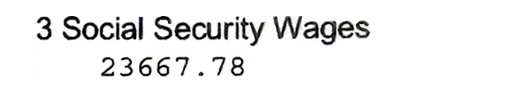

In [127]:
chrs, space_dic = crop_(url)

In [128]:
ocr(chrs, x_train[:100], space_dic)

NameError: name 'make_center' is not defined

In [104]:
"\n3SocialseMrityW5ges\n23667l78".split("\n")

['', '3SocialseMrityW5ges', '23667l78']

In [144]:
img = Image.open(url)

In [149]:
img = img.convert("L")

In [42]:
a = ([1,2,3], [4,5,6])

In [43]:
b = a

In [47]:
b[0].pop(0)

1

In [50]:
b[0]

[2, 3]

In [51]:
a

([2, 3], [4, 5, 6])

In [125]:
temp = "3SocialSeMrityW5ges\n23667.78"

In [126]:
space_list

[1, 7, 14]

In [127]:
line = temp.split("\n")[0]
line = list(line)
for idx, space in enumerate(space_list):
    line.insert(space + idx, " ")
line = "".join(line)

In [128]:
temp

'3SocialSeMrityW5ges\n23667.78'